In [62]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import tensorflow as tf                # TensorFlow for datasets
import tensorflow_datasets as tfds    # TensorFlow Datasets
tf.__version__

'2.16.1'

## Loading Datasets and Labels

In [73]:
def get_datasets():
  """Load MNIST train and test datasets into memory."""
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 127.5 - 1.
  test_ds['image'] = jnp.float32(test_ds['image']) / 127.5 - 1.
  return train_ds, test_ds

def get_labels(train_ds, test_ds):
    """Extract labels from train and test datasets."""
    train_labels = train_ds['label']
    test_labels = test_ds['label']
    return train_labels, test_labels

train_images, test_images = get_datasets()
train_labels, test_labels = get_labels(train_images, test_images)

def print_weights(model_state):
    weights = []
    for layer_name, layer_params in model_state.params.items():
        print(f"Weights of layer {layer_name}:")
        weights.append(layer_params['kernel'].tolist())
        print(layer_params['kernel'])
    return weights

In [74]:

import pickle as pkl
import matplotlib.pyplot as plt
img = test_images['image'][1].reshape(28, 28).tolist()
#pkl.dump(img, open("imgs/MNIST:test-image-01", "wb" ))

In [64]:
imgs = [img.reshape(28, 28).tolist() for img in test_images['image'][0:150]]
print(test_labels)
labels = test_labels[0:150]
pkl.dump(imgs, open("imgs/MNIST:images-for-verification", "wb" ))
pkl.dump(labels, open("imgs/MNIST:labels-for-verification", "wb" ))

[2 0 4 ... 8 0 5]


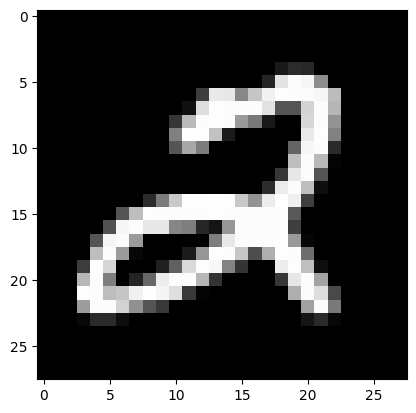

In [65]:
import matplotlib.pyplot as plt
plt.imshow(imgs[0], cmap="gray")

## Defining Activation Functions

In [66]:
# Defining the dorefa activation function using a similar mathematical framework as defined in the larq docs

def dorefa_activation(x, k_bits = 2):
    n = 2**k_bits - 1
    
    # First, apply the sigmoid activation function to squash the values between 0 and 1
    x = nn.sigmoid(x)

    # Then, quantize the values into a number of discrete intervals
    x = jnp.round(x * n) / n

    return x

def binary_step( x):
    return jnp.where(x >= 0, 1, 0)


In [67]:
def l1_loss_func(params):
    l1_loss = 0
    for p in jax.tree.leaves(params):
      l1_loss += jnp.mean(jnp.abs(p))
      l1_loss = l1_loss * 0.75
    return l1_loss

def cross_entropy_loss(*, params, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=10)
  output_loss = optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

  l1_loss = 0
  l1_loss = l1_loss_func(params)
  return output_loss + l1_loss 

def compute_metrics(*, params, logits, labels):
  loss = cross_entropy_loss(params=params, logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics


In [68]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_metrics = []
  for perm in perms:
    batch = {k: v[perm, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)

  # compute mean of metrics across each batch in epoch.
  batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: np.mean([metrics[k] for metrics in batch_metrics_np])
      for k in batch_metrics_np[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

  return state

In [69]:
def eval_model(params, test_ds):
  metrics = eval_step(params, test_ds)
  metrics = jax.device_get(metrics)
  summary = jax.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy']

# Binary Activation - 2 Hidden Layers

In [11]:
class Dense_2_Hidden(nn.Module):
  """A simple 2 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else binary_step(x) # Smooth function for training, Binary Step for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else binary_step(x) # Smooth function for training, Binary Step for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x

Eval & Train Step 2 Hidden Layer

In [12]:


def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dense_2_Hidden(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dense_2_Hidden(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dense_2_Hidden(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])

rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
momentum = 0.9
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

In [13]:
print(state)

TrainState(step=0, apply_fn=<bound method Module.apply of Dense_2_Hidden(
    # attributes
    is_deployed = False
)>, params={'Dense_0': {'kernel': Array([[ 0.01902316,  0.00998085,  0.0510776 , ..., -0.03486988,
        -0.00220674,  0.06837985],
       [-0.03483726,  0.04313357,  0.00236818, ..., -0.02111995,
         0.05879913,  0.016203  ],
       [ 0.00447755,  0.03352144, -0.01148568, ...,  0.08007551,
         0.00797571,  0.02102956],
       ...,
       [ 0.00442723,  0.01658102,  0.04113685, ...,  0.03358691,
         0.01802473,  0.02458535],
       [-0.01395124,  0.03456584, -0.00800512, ...,  0.0114007 ,
        -0.05030964, -0.02679757],
       [ 0.0468614 ,  0.06096169, -0.00474466, ...,  0.02635906,
        -0.03182237, -0.04279813]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [14]:

num_epochs = 25
batch_size = 100
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  


train epoch: 1, loss: 1.8521, accuracy: 70.71
 test epoch: 1, loss: 1.70, accuracy: 84.79
train epoch: 2, loss: 1.6606, accuracy: 90.75
 test epoch: 2, loss: 1.63, accuracy: 92.41
train epoch: 3, loss: 1.6212, accuracy: 93.92
 test epoch: 3, loss: 1.60, accuracy: 94.97
train epoch: 4, loss: 1.6045, accuracy: 95.02
 test epoch: 4, loss: 1.59, accuracy: 95.37
train epoch: 5, loss: 1.5933, accuracy: 95.76
 test epoch: 5, loss: 1.58, accuracy: 96.02
train epoch: 6, loss: 1.5834, accuracy: 96.28
 test epoch: 6, loss: 1.57, accuracy: 96.21
train epoch: 7, loss: 1.5764, accuracy: 96.69
 test epoch: 7, loss: 1.57, accuracy: 96.47
train epoch: 8, loss: 1.5699, accuracy: 97.05
 test epoch: 8, loss: 1.57, accuracy: 96.67
train epoch: 9, loss: 1.5640, accuracy: 97.38
 test epoch: 9, loss: 1.56, accuracy: 96.78
train epoch: 10, loss: 1.5594, accuracy: 97.61
 test epoch: 10, loss: 1.56, accuracy: 96.97
train epoch: 11, loss: 1.5550, accuracy: 97.83
 test epoch: 11, loss: 1.56, accuracy: 97.01
train 

In [15]:
def check_sparsity(params, threshold=0.5):
    total_weights = 0
    zero_weights = 0

    for p in jax.tree.leaves(params):
        print("node weight:",p.size, "/n")
        total_weights += p.size
        zero_weights += jnp.sum(p < 1e-3)

    sparsity = zero_weights / total_weights

    print(f"Sparsity: {sparsity * 100:.2f}%")

    if sparsity > threshold:
        print("The weights are sparse.")
    else:
        print("The weights are not sparse.")

check_sparsity(state.params)

def print_layer_params(params, layer_name):
    layer_params = params[layer_name]
    jax.tree_map(print, layer_params)
print_layer_params(state.params, 'Dense_1') 

node weight: 256 /n
node weight: 200704 /n
node weight: 256 /n
node weight: 65536 /n
node weight: 10 /n
node weight: 2560 /n
Sparsity: 60.19%
The weights are sparse.
[ 4.31078661e-05 -1.18404671e-04  1.08049207e-04  2.62871054e-05
  7.95005471e-05  1.28782005e-04 -1.02615797e-06  4.87036392e-04
 -1.79317591e-04  5.83318179e-05 -5.78179533e-05 -5.44581038e-04
  7.53958318e-07 -1.54982146e-04  4.92373074e-05  1.88105463e-04
  2.01176081e-04  1.17644311e-04 -1.32008190e-05  1.03621816e-04
  1.56291338e-04  3.52096613e-05 -7.46898659e-05  2.57756386e-04
  5.40848378e-05  6.37918856e-05  1.48980238e-04  4.26753322e-05
  1.39850410e-04  1.26214116e-04  5.29754834e-05  1.92524283e-04
  1.02059003e-05 -4.67753598e-05 -1.06414402e-04 -2.10521503e-05
  2.58179090e-04 -1.30906774e-04  1.89433878e-04 -6.45868349e-05
 -1.53974524e-05  3.33159733e-06  3.67694920e-05 -3.95459538e-05
 -7.61984906e-04  5.25816858e-07  1.55603047e-04 -2.53835788e-05
 -1.52752778e-04  9.26801877e-05 -7.64515644e-05 -2.09

In [16]:
import pickle as pkl

params_list = print_weights(state)
print(params_list[0], "\n")
pkl.dump(params_list, open( "models/MNIST-BAN_Dense256-Dense256.pkl", "wb"))

Weights of layer Dense_0:
[[ 0.00334366  0.01594531  0.03072823 ... -0.00352703  0.00468877
   0.00195429]
 [ 0.00299706  0.04909797  0.00104791 ... -0.00350838  0.02034779
   0.00196386]
 [ 0.00299555  0.03948583  0.00104802 ... -0.00351019  0.00467189
   0.00197299]
 ...
 [ 0.00299869  0.02254553  0.02078754 ... -0.00352762  0.00468833
   0.00195559]
 [ 0.00298944  0.04053022  0.00104079 ... -0.00350884  0.00467476
   0.00197599]
 [ 0.02921851  0.066926    0.00104469 ... -0.00352383  0.00467077
   0.00196027]]
Weights of layer Dense_1:
[[ 1.80911447e-04 -1.77326598e-04  1.70949468e-04 ... -3.48481699e-04
  -2.46363255e-04  1.33210851e-04]
 [ 5.38666973e-05  2.13959065e-05  5.15973479e-05 ... -6.31300281e-05
  -1.67789709e-04  1.01554477e-04]
 [ 3.24428634e-04 -5.31955520e-05 -1.32581292e-04 ...  6.50703951e-05
   1.39925527e-04  1.01933285e-04]
 ...
 [-1.67505670e-04 -7.98821638e-05  3.82219005e-05 ... -2.82317371e-04
  -2.26337754e-04  1.83395838e-04]
 [-1.26370709e-04 -1.16663934e-

# Binary Activation - 3 Hidden Layers

In [17]:
class Dense_3_Hidden(nn.Module):
  """A simple 3 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else binary_step(x) # Smooth function for training, Binary Step for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else binary_step(x) # Smooth function for training, Binary Step for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else binary_step(x) # Smooth function for training, Binary Step for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


Eval & Train Step 3 Hidden Layer

In [18]:


def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dense_3_Hidden(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dense_3_Hidden(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dense_3_Hidden(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [19]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
momentum = 0.9
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 25
batch_size = 100
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
pkl.dump(params_list, open( "models/MNIST-BAN_Dense100-Dense100-Dense100.pkl", "wb" ))

train epoch: 1, loss: 1.8979, accuracy: 66.45
 test epoch: 1, loss: 1.73, accuracy: 82.03
train epoch: 2, loss: 1.6940, accuracy: 87.19
 test epoch: 2, loss: 1.63, accuracy: 92.77
train epoch: 3, loss: 1.6235, accuracy: 93.78
 test epoch: 3, loss: 1.60, accuracy: 94.75
train epoch: 4, loss: 1.6042, accuracy: 95.06
 test epoch: 4, loss: 1.59, accuracy: 95.18
train epoch: 5, loss: 1.5908, accuracy: 95.94
 test epoch: 5, loss: 1.58, accuracy: 95.97
train epoch: 6, loss: 1.5803, accuracy: 96.54
 test epoch: 6, loss: 1.58, accuracy: 95.73
train epoch: 7, loss: 1.5728, accuracy: 96.95
 test epoch: 7, loss: 1.58, accuracy: 95.66
train epoch: 8, loss: 1.5679, accuracy: 97.15
 test epoch: 8, loss: 1.57, accuracy: 95.99
train epoch: 9, loss: 1.5624, accuracy: 97.41
 test epoch: 9, loss: 1.57, accuracy: 96.49
train epoch: 10, loss: 1.5579, accuracy: 97.60
 test epoch: 10, loss: 1.57, accuracy: 95.92
train epoch: 11, loss: 1.5540, accuracy: 97.76
 test epoch: 11, loss: 1.57, accuracy: 96.43
train 

# Dorefa k_bit = 2

In [20]:
class Dorefa_2_Hidden(nn.Module):
  """A simple 3 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


In [21]:

def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dorefa_2_Hidden(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dorefa_2_Hidden(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dorefa_2_Hidden(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [22]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 25
batch_size = 130
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
pkl.dump(params_list, open( "models/MNIST-DoReFa2_Dense256-Dense256.pkl", "wb" ))

train epoch: 1, loss: 1.8756, accuracy: 68.28
 test epoch: 1, loss: 1.72, accuracy: 84.37
train epoch: 2, loss: 1.6795, accuracy: 88.98
 test epoch: 2, loss: 1.63, accuracy: 93.07
train epoch: 3, loss: 1.6286, accuracy: 93.56
 test epoch: 3, loss: 1.61, accuracy: 94.32
train epoch: 4, loss: 1.6110, accuracy: 94.71
 test epoch: 4, loss: 1.60, accuracy: 94.94
train epoch: 5, loss: 1.5991, accuracy: 95.47
 test epoch: 5, loss: 1.59, accuracy: 95.64
train epoch: 6, loss: 1.5896, accuracy: 96.07
 test epoch: 6, loss: 1.58, accuracy: 95.94
train epoch: 7, loss: 1.5822, accuracy: 96.49
 test epoch: 7, loss: 1.58, accuracy: 96.54
train epoch: 8, loss: 1.5760, accuracy: 96.81
 test epoch: 8, loss: 1.58, accuracy: 96.28
train epoch: 9, loss: 1.5702, accuracy: 97.20
 test epoch: 9, loss: 1.57, accuracy: 96.84
train epoch: 10, loss: 1.5648, accuracy: 97.43
 test epoch: 10, loss: 1.57, accuracy: 96.98
train epoch: 11, loss: 1.5601, accuracy: 97.67
 test epoch: 11, loss: 1.56, accuracy: 97.31
train 

In [45]:
params_list[0]

Array([[ 0.0018337 ,  0.00387429,  0.02206494, ..., -0.04202599,
         0.00956637, -0.00324762],
       [ 0.00184086,  0.00387397,  0.0002243 , ..., -0.02827607,
         0.05950673, -0.00536319],
       [ 0.00183346,  0.00386751,  0.00023027, ..., -0.00146495,
         0.01004845, -0.00402584],
       ...,
       [ 0.00184423,  0.00387351,  0.01212416, ..., -0.00213088,
         0.01873248, -0.00377238],
       [ 0.00184439,  0.00386778,  0.00022708, ..., -0.00597406,
         0.00956248, -0.04026318],
       [ 0.0018459 ,  0.0038774 ,  0.00022491, ..., -0.00280627,
         0.00956078, -0.05626373]], dtype=float32)

# Dorefa k_bit = 3

In [70]:
class Dorefa_3_Hidden(nn.Module):
  """A simple 3 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 3) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 3) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


In [71]:

def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dorefa_3_Hidden(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dorefa_3_Hidden(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dorefa_3_Hidden(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [75]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 30
batch_size = 130
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
len(params_list)
pkl.dump(params_list, open( "models/MNIST-DoReFa3_Dense256-Dense256.pkl", "wb" ))

train epoch: 1, loss: 1.8756, accuracy: 68.28
 test epoch: 1, loss: 1.72, accuracy: 84.30
train epoch: 2, loss: 1.6795, accuracy: 88.98
 test epoch: 2, loss: 1.63, accuracy: 93.07
train epoch: 3, loss: 1.6286, accuracy: 93.56
 test epoch: 3, loss: 1.62, accuracy: 94.37
train epoch: 4, loss: 1.6110, accuracy: 94.71
 test epoch: 4, loss: 1.61, accuracy: 94.86
train epoch: 5, loss: 1.5991, accuracy: 95.47
 test epoch: 5, loss: 1.59, accuracy: 95.70
train epoch: 6, loss: 1.5896, accuracy: 96.07
 test epoch: 6, loss: 1.59, accuracy: 96.06
train epoch: 7, loss: 1.5822, accuracy: 96.49
 test epoch: 7, loss: 1.58, accuracy: 96.58
train epoch: 8, loss: 1.5760, accuracy: 96.81
 test epoch: 8, loss: 1.58, accuracy: 96.24
train epoch: 9, loss: 1.5702, accuracy: 97.20
 test epoch: 9, loss: 1.57, accuracy: 96.86
train epoch: 10, loss: 1.5648, accuracy: 97.43
 test epoch: 10, loss: 1.57, accuracy: 96.89
train epoch: 11, loss: 1.5601, accuracy: 97.67
 test epoch: 11, loss: 1.56, accuracy: 97.26
train 

In [60]:
#params_list = print_weights(state)
print(len(params_list), "\n")
#print(params_list[0], "\n")

3 

[[0.004157562740147114, 0.0174439437687397, 0.020614705979824066, 0.004161262884736061, 0.0016662885900586843, -0.000962825317401439, -0.015508182346820831, 0.06634596735239029, -0.0022715332452207804, -0.0010025313822552562, 0.023436961695551872, 0.001980108441784978, 0.0026665932964533567, -0.0006286381394602358, -0.001150830532424152, -0.0007152284379117191, 0.00022699743567500263, -0.001973997801542282, 0.0008664682973176241, -0.00033092795638367534, 0.0010112994350492954, 0.0027050224598497152, 0.017188208177685738, 0.002746617654338479, -0.00048281607450917363, 0.0015367565210908651, 0.0016739433631300926, 0.0030451458878815174, 0.000281983899185434, -0.0005622478201985359, -0.011297506280243397, 0.024988772347569466, 0.0022147290874272585, -0.0046669794246554375, -0.0020963388960808516, 0.0004194595676381141, 0.00030604665516875684, 0.005531564354896545, 0.0012984259519726038, -0.002673784736543894, -0.0004199263930786401, 0.0002195663983002305, 7.759896834613755e-05, 0.0043

# Dorefa k = 4

In [26]:
class Dorefa_4_Hidden(nn.Module):
  """A simple 3 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 4) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 4) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


In [27]:

def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dorefa_4_Hidden(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dorefa_4_Hidden(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dorefa_4_Hidden(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [28]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 30
batch_size = 130
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
pkl.dump(params_list, open( "models/MNIST-DoReFa4_Dense256-Dense256-Dense256.pkl", "wb" ))

train epoch: 1, loss: 1.8756, accuracy: 68.28
 test epoch: 1, loss: 1.72, accuracy: 84.25
train epoch: 2, loss: 1.6795, accuracy: 88.98
 test epoch: 2, loss: 1.64, accuracy: 92.98
train epoch: 3, loss: 1.6286, accuracy: 93.56
 test epoch: 3, loss: 1.62, accuracy: 94.38
train epoch: 4, loss: 1.6110, accuracy: 94.71
 test epoch: 4, loss: 1.61, accuracy: 94.93
train epoch: 5, loss: 1.5991, accuracy: 95.47
 test epoch: 5, loss: 1.59, accuracy: 95.67
train epoch: 6, loss: 1.5896, accuracy: 96.07
 test epoch: 6, loss: 1.59, accuracy: 96.13
train epoch: 7, loss: 1.5822, accuracy: 96.49
 test epoch: 7, loss: 1.58, accuracy: 96.54
train epoch: 8, loss: 1.5760, accuracy: 96.81
 test epoch: 8, loss: 1.58, accuracy: 96.22
train epoch: 9, loss: 1.5702, accuracy: 97.20
 test epoch: 9, loss: 1.57, accuracy: 96.81
train epoch: 10, loss: 1.5648, accuracy: 97.43
 test epoch: 10, loss: 1.57, accuracy: 96.95
train epoch: 11, loss: 1.5601, accuracy: 97.67
 test epoch: 11, loss: 1.56, accuracy: 97.24
train 

# Dorefa k = 5

In [29]:
class Dorefa_5_Hidden(nn.Module):
  """A simple 2 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 5) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 5) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


In [30]:

def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dorefa_5_Hidden(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dorefa_5_Hidden(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dorefa_5_Hidden(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [31]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 30
batch_size = 130
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
pkl.dump(params_list, open( "models/MNIST-DoReFa5_Dense256-Dense256.pkl", "wb" ))

train epoch: 1, loss: 1.8756, accuracy: 68.28
 test epoch: 1, loss: 1.72, accuracy: 84.26
train epoch: 2, loss: 1.6795, accuracy: 88.98
 test epoch: 2, loss: 1.64, accuracy: 93.10
train epoch: 3, loss: 1.6286, accuracy: 93.56
 test epoch: 3, loss: 1.62, accuracy: 94.33
train epoch: 4, loss: 1.6110, accuracy: 94.71
 test epoch: 4, loss: 1.61, accuracy: 94.94
train epoch: 5, loss: 1.5991, accuracy: 95.47
 test epoch: 5, loss: 1.60, accuracy: 95.69
train epoch: 6, loss: 1.5896, accuracy: 96.07
 test epoch: 6, loss: 1.59, accuracy: 96.08
train epoch: 7, loss: 1.5822, accuracy: 96.49
 test epoch: 7, loss: 1.58, accuracy: 96.52
train epoch: 8, loss: 1.5760, accuracy: 96.81
 test epoch: 8, loss: 1.58, accuracy: 96.23
train epoch: 9, loss: 1.5702, accuracy: 97.20
 test epoch: 9, loss: 1.57, accuracy: 96.84
train epoch: 10, loss: 1.5648, accuracy: 97.43
 test epoch: 10, loss: 1.57, accuracy: 96.97
train epoch: 11, loss: 1.5601, accuracy: 97.67
 test epoch: 11, loss: 1.56, accuracy: 97.24
train 

# Dorefa k = 6

In [32]:
class Dorefa_6_Hidden(nn.Module):
  """A simple 2 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 6) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 6) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


In [33]:

def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dorefa_6_Hidden(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dorefa_6_Hidden(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dorefa_6_Hidden(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [34]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 30
batch_size = 130
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
pkl.dump(params_list, open( "models/MNIST-DoReFa6_Dense256-Dense256.pkl", "wb" ))

train epoch: 1, loss: 1.8756, accuracy: 68.28
 test epoch: 1, loss: 1.72, accuracy: 84.29
train epoch: 2, loss: 1.6795, accuracy: 88.98
 test epoch: 2, loss: 1.64, accuracy: 93.05
train epoch: 3, loss: 1.6286, accuracy: 93.56
 test epoch: 3, loss: 1.62, accuracy: 94.33
train epoch: 4, loss: 1.6110, accuracy: 94.71
 test epoch: 4, loss: 1.61, accuracy: 94.95
train epoch: 5, loss: 1.5991, accuracy: 95.47
 test epoch: 5, loss: 1.60, accuracy: 95.68
train epoch: 6, loss: 1.5896, accuracy: 96.07
 test epoch: 6, loss: 1.59, accuracy: 96.11
train epoch: 7, loss: 1.5822, accuracy: 96.49
 test epoch: 7, loss: 1.58, accuracy: 96.51
train epoch: 8, loss: 1.5760, accuracy: 96.81
 test epoch: 8, loss: 1.58, accuracy: 96.22
train epoch: 9, loss: 1.5702, accuracy: 97.20
 test epoch: 9, loss: 1.57, accuracy: 96.85
train epoch: 10, loss: 1.5648, accuracy: 97.43
 test epoch: 10, loss: 1.57, accuracy: 96.97
train epoch: 11, loss: 1.5601, accuracy: 97.67
 test epoch: 11, loss: 1.56, accuracy: 97.24
train 

# Dorefa k = 7

In [35]:
class Dorefa_7_Hidden(nn.Module):
  """A simple 2 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 7) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 7) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


In [36]:

def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dorefa_7_Hidden(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dorefa_7_Hidden(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dorefa_7_Hidden(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [37]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 30
batch_size = 130
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
pkl.dump(params_list, open( "models/MNIST-DoReFa7_Dense256-Dense256.pkl", "wb" ))

train epoch: 1, loss: 1.8756, accuracy: 68.28
 test epoch: 1, loss: 1.72, accuracy: 84.28
train epoch: 2, loss: 1.6795, accuracy: 88.98
 test epoch: 2, loss: 1.64, accuracy: 93.05
train epoch: 3, loss: 1.6286, accuracy: 93.56
 test epoch: 3, loss: 1.62, accuracy: 94.33
train epoch: 4, loss: 1.6110, accuracy: 94.71
 test epoch: 4, loss: 1.61, accuracy: 94.95
train epoch: 5, loss: 1.5991, accuracy: 95.47
 test epoch: 5, loss: 1.60, accuracy: 95.68
train epoch: 6, loss: 1.5896, accuracy: 96.07
 test epoch: 6, loss: 1.59, accuracy: 96.09
train epoch: 7, loss: 1.5822, accuracy: 96.49
 test epoch: 7, loss: 1.58, accuracy: 96.51
train epoch: 8, loss: 1.5760, accuracy: 96.81
 test epoch: 8, loss: 1.58, accuracy: 96.21
train epoch: 9, loss: 1.5702, accuracy: 97.20
 test epoch: 9, loss: 1.57, accuracy: 96.86
train epoch: 10, loss: 1.5648, accuracy: 97.43
 test epoch: 10, loss: 1.57, accuracy: 96.96
train epoch: 11, loss: 1.5601, accuracy: 97.67
 test epoch: 11, loss: 1.56, accuracy: 97.23
train 

# Dorefa k = 2 with 3 hidden layers

In [38]:
class Dorefa_2_Hidden_3(nn.Module):
  """A simple 3 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


In [39]:

def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dorefa_2_Hidden_3(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dorefa_2_Hidden_3(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dorefa_2_Hidden_3(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [40]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 30
batch_size = 130
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
pkl.dump(params_list, open( "models/MNIST-DoReFa2_Dense256-Dense256-Dense256.pkl", "wb" ))

train epoch: 1, loss: 1.9396, accuracy: 61.49
 test epoch: 1, loss: 1.76, accuracy: 81.03
train epoch: 2, loss: 1.7240, accuracy: 84.25
 test epoch: 2, loss: 1.66, accuracy: 90.90
train epoch: 3, loss: 1.6352, accuracy: 92.96
 test epoch: 3, loss: 1.62, accuracy: 94.23
train epoch: 4, loss: 1.6115, accuracy: 94.58
 test epoch: 4, loss: 1.60, accuracy: 95.21
train epoch: 5, loss: 1.5973, accuracy: 95.59
 test epoch: 5, loss: 1.59, accuracy: 95.86
train epoch: 6, loss: 1.5863, accuracy: 96.27
 test epoch: 6, loss: 1.58, accuracy: 96.24
train epoch: 7, loss: 1.5788, accuracy: 96.74
 test epoch: 7, loss: 1.58, accuracy: 96.53
train epoch: 8, loss: 1.5727, accuracy: 97.03
 test epoch: 8, loss: 1.57, accuracy: 96.45
train epoch: 9, loss: 1.5677, accuracy: 97.28
 test epoch: 9, loss: 1.57, accuracy: 96.84
train epoch: 10, loss: 1.5613, accuracy: 97.61
 test epoch: 10, loss: 1.56, accuracy: 97.07
train epoch: 11, loss: 1.5579, accuracy: 97.76
 test epoch: 11, loss: 1.56, accuracy: 97.14
train 

# Dorefa k = 3 with 3 hidden layers

In [41]:
class Dorefa_3_Hidden_3(nn.Module):
  """A simple 3 layer dense model."""
  is_deployed: bool # allows to switch from sigmoid to binary step for deployment

  def deploy_status(self, deploy_status):
    self.is_deployed = deploy_status
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))  # flatten the images
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 3) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 3) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=256)(x)
    x = nn.sigmoid(x) if not self.is_deployed else dorefa_activation(x, 3) # Smooth function for training, DoReFa for deployment
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x


In [42]:

def create_train_state(rng, learning_rate):
  """Creates initial `TrainState`."""
  model = Dorefa_3_Hidden_3(False) ## Changes based on which model we're trying to train (needs to be changed for model)
  params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  tx = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = Dorefa_3_Hidden_3(False).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
    loss = cross_entropy_loss(params=params, logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(params=state.params, logits=logits, labels=batch['label'])
  return state, metrics

@jax.jit
def eval_step(params, batch):
  logits = Dorefa_3_Hidden_3(True).apply({'params': params}, batch['image']) ## Changes based on which model we're trying to train (needs to be changed for model)
  return compute_metrics(params=params, logits=logits, labels=batch['label'])


In [43]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 1e-3
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

num_epochs = 30
batch_size = 130
for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)

  # Run an optimization step over a training batch
  state = train_epoch(state, train_images, batch_size, epoch, input_rng)
  
  # Evaluate on the test set after each training epoch 
  test_loss, test_accuracy = eval_model(state.params, test_images)
  print(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (
      epoch, test_loss, test_accuracy * 100))
  
import pickle as pkl
params = state.params
params_list = print_weights(state)
pkl.dump(params_list, open( "models/MNIST-DoReFa3_Dense256-Dense256-Dense256.pkl", "wb" ))

train epoch: 1, loss: 1.9396, accuracy: 61.49
 test epoch: 1, loss: 1.76, accuracy: 81.15
train epoch: 2, loss: 1.7240, accuracy: 84.25
 test epoch: 2, loss: 1.66, accuracy: 91.02
train epoch: 3, loss: 1.6352, accuracy: 92.96
 test epoch: 3, loss: 1.62, accuracy: 94.20
train epoch: 4, loss: 1.6115, accuracy: 94.58
 test epoch: 4, loss: 1.60, accuracy: 95.18
train epoch: 5, loss: 1.5973, accuracy: 95.59
 test epoch: 5, loss: 1.59, accuracy: 95.73
train epoch: 6, loss: 1.5863, accuracy: 96.27
 test epoch: 6, loss: 1.58, accuracy: 96.30
train epoch: 7, loss: 1.5788, accuracy: 96.74
 test epoch: 7, loss: 1.58, accuracy: 96.52
train epoch: 8, loss: 1.5727, accuracy: 97.03
 test epoch: 8, loss: 1.58, accuracy: 96.32
train epoch: 9, loss: 1.5677, accuracy: 97.28
 test epoch: 9, loss: 1.57, accuracy: 96.70
train epoch: 10, loss: 1.5613, accuracy: 97.61
 test epoch: 10, loss: 1.56, accuracy: 97.14
train epoch: 11, loss: 1.5579, accuracy: 97.76
 test epoch: 11, loss: 1.56, accuracy: 97.08
train 

In [44]:
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer=None,
              kernel_constraint=None)

model = tf.keras.models.Sequential()

# In the first layer we only quantize the weights and not the input
model.add(lq.layers.QuantConv2D(32, (3, 3),
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))

model.add(lq.layers.QuantConv2D(64, (3, 3), use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())

model.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))

NameError: name 'lq' is not defined

In [ ]:
model.build()
lq.models.summary(model)

+sequential_7 stats----------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  32-bit MACs |
|                              (bit)                        x 1       x 1    (kB)              |
+----------------------------------------------------------------------------------------------+
| quant_conv2d_3                   -  (-1, 26, 26, 32)      288         0    0.04       194688 |
| max_pooling2d_2                  -  (-1, 13, 13, 32)        0         0       0            0 |
| batch_normalization_5            -  (-1, 13, 13, 32)        0        64    0.25            0 |
| quant_conv2d_4                   1  (-1, 11, 11, 64)        0     18432   72.00      2230272 |
| max_pooling2d_3                  -    (-1, 5, 5, 64)        0         0       0            0 |
| batch_normalization_6            -    (-1, 5, 5, 64)        0       128    0.50            0 |
| quant_conv2d_5              

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, batch_size=128, epochs=20)

test_loss, test_acc = model.evaluate(test_images, test_labels)

Epoch 1/20
469/469 [==============================] - 13s 26ms/step - loss: 0.5885 - accuracy: 0.9247
Epoch 2/20
469/469 [==============================] - 12s 26ms/step - loss: 0.4233 - accuracy: 0.9713
Epoch 3/20
469/469 [==============================] - 12s 26ms/step - loss: 0.3923 - accuracy: 0.9791
Epoch 4/20
469/469 [==============================] - 12s 26ms/step - loss: 0.3787 - accuracy: 0.9827
Epoch 5/20
469/469 [==============================] - 12s 26ms/step - loss: 0.3691 - accuracy: 0.9850
Epoch 6/20
469/469 [==============================] - 12s 26ms/step - loss: 0.3646 - accuracy: 0.9867
Epoch 7/20
469/469 [==============================] - 12s 26ms/step - loss: 0.3621 - accuracy: 0.9869
Epoch 8/20
469/469 [==============================] - 12s 26ms/step - loss: 0.3587 - accuracy: 0.9879
Epoch 9/20
469/469 [==============================] - 12s 26ms/step - loss: 0.3570 - accuracy: 0.9887
Epoch 10/20
469/469 [==============================] - 12s 26ms/step - loss: 0.352

In [ ]:
kwargs = dict(#activation="ste_sign",
              input_quantizer="ste_sign",
              kernel_quantizer=None,
              kernel_constraint=None)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
model.add(lq.layers.QuantDense(100, activation = "ste_sign"))
model.add(lq.layers.QuantDense(100, activation = "ste_sign"))
model.add(lq.layers.QuantDense(10))
model.add(tf.keras.layers.Activation("softmax"))

In [ ]:
model.build()
lq.models.summary(model)

+sequential_4 stats-----------------------------------------------------+
| Layer           Input prec.    Outputs  # 32-bit  Memory  32-bit MACs |
|                       (bit)                  x 1    (kB)              |
+-----------------------------------------------------------------------+
| flatten_4                 -  (-1, 784)         0       0            0 |
| quant_dense_12            -  (-1, 100)     78500  306.64        78400 |
| quant_dense_13            -  (-1, 100)     10100   39.45        10000 |
| quant_dense_14            -   (-1, 10)      1010    3.95         1000 |
| activation_4              -   (-1, 10)         0       0            ? |
+-----------------------------------------------------------------------+
| Total                                      89610  350.04        89400 |
+-----------------------------------------------------------------------+
+sequential_4 summary-----------------------+
| Total params                   89.6 k     |
| Trainable params  

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, batch_size=130, epochs=15)

test_loss, test_acc = model.evaluate(test_images, test_labels)

Epoch 1/15
462/462 [==============================] - 1s 2ms/step - loss: 0.4666 - accuracy: 0.8581
Epoch 2/15
462/462 [==============================] - 1s 1ms/step - loss: 0.2428 - accuracy: 0.9272
Epoch 3/15
462/462 [==============================] - 1s 1ms/step - loss: 0.1951 - accuracy: 0.9409
Epoch 4/15
462/462 [==============================] - 1s 1ms/step - loss: 0.1693 - accuracy: 0.9476
Epoch 5/15
462/462 [==============================] - 1s 1ms/step - loss: 0.1462 - accuracy: 0.9556
Epoch 6/15
462/462 [==============================] - 1s 1ms/step - loss: 0.1367 - accuracy: 0.9582
Epoch 7/15
462/462 [==============================] - 1s 1ms/step - loss: 0.1266 - accuracy: 0.9617
Epoch 8/15
462/462 [==============================] - 1s 2ms/step - loss: 0.1198 - accuracy: 0.9623
Epoch 9/15
462/462 [==============================] - 1s 2ms/step - loss: 0.1153 - accuracy: 0.9629
Epoch 10/15
462/462 [==============================] - 1s 2ms/step - loss: 0.1074 - accuracy: 0.9662

In [ ]:
w = [layer.numpy().tolist() for layer in model.weights]

In [ ]:
imgs = test_images[3].reshape(1, 784)
#imgs = [-1 if val < 0 else 1 for val in imgs]

In [ ]:
act = np.dot(imgs, w[0])[0] + w[1]
act = [-1 if val < 0 else 1 for val in act]

act = np.dot(act, w[2]) + w[3]
act = [-1 if val < 0 else 1 for val in act]

act = np.dot(act, w[4]) + w[5]

In [ ]:
act

array([ 9.45391659, -5.65162886, -1.2868103 , -1.92257238, -0.99960611,
        1.96356583,  0.98562209, -0.08623952, -1.12861554, -2.12513343])

In [ ]:
test_labels[0:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

In [ ]:
import numpy as np
import pickle as pkl
w = [layer.numpy().tolist() for layer in model.weights]
pkl.dump(w, open( "models/MNIST-BAN:Dense100-Dense100.pkl", "wb" ))

In [ ]:
type(w[0])

list

In [ ]:
w[0]

[[0.0637546256184578,
  0.030542615801095963,
  0.0796964168548584,
  0.06956490129232407,
  0.04486523196101189,
  -0.059023354202508926,
  0.0738808736205101,
  -0.0026578903198242188,
  -0.06871047616004944,
  -0.009264478459954262,
  -0.016163378953933716,
  -0.035512786358594894,
  0.08337853848934174,
  0.08374547213315964,
  -0.04312192648649216,
  -0.029212981462478638,
  0.06428186595439911,
  -0.026001043617725372,
  0.09234310686588287,
  -0.058235544711351395,
  0.06940394639968872,
  0.061434462666511536,
  0.05023553594946861,
  -0.04448790103197098,
  0.008390898816287518,
  -0.07809308171272278,
  -0.032911818474531174,
  -0.023587368428707123,
  0.05052519217133522,
  0.025138868018984795,
  -0.036732710897922516,
  0.055366743355989456,
  -0.056112878024578094,
  0.07005572319030762,
  0.010847085155546665,
  -0.0021860403940081596,
  0.004077828023582697,
  -0.02103039063513279,
  -0.1088595762848854,
  0.05028478056192398,
  0.030831748619675636,
  0.030790962278842

In [ ]:
w[1]

[-0.008920266292989254,
 -0.005168737843632698,
 -0.0033934179227799177,
 -0.03224657103419304,
 0.013476555235683918,
 -0.012305094860494137,
 -0.01248625386506319,
 -0.0074222818948328495,
 0.0075399004854261875,
 -0.010488776490092278,
 -0.013717134483158588,
 -0.015170364640653133,
 -0.009131550788879395,
 -0.007520527113229036,
 0.001637675566598773,
 0.01220338698476553,
 -0.00717143202200532,
 -0.00038180005503818393,
 -0.0125482939183712,
 0.010805278085172176,
 -0.017717698588967323,
 0.00857036467641592,
 -0.010505269281566143,
 0.014247585088014603,
 0.016965366899967194,
 0.0063799605704844,
 -0.009240199811756611,
 -0.00884515792131424,
 0.0017160468269139528,
 0.007770318537950516,
 0.007720780558884144,
 0.0049924603663384914,
 -0.0027260438073426485,
 -0.0003922330215573311,
 -0.004631131421774626,
 0.0018754801712930202,
 -0.0025095317978411913,
 -0.013659493997693062,
 0.032334890216588974,
 0.009706801734864712,
 -0.01456938125193119,
 0.010412557050585747,
 -0.00266